In [1]:
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt

In [2]:
import pymc
import arviz as az

In [3]:
from matplotlib import cm

## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*



### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



$( \alpha^2 $)

/tmp/ipykernel_52/698701172.py:26: RuntimeWarning: invalid value encountered in scalar divide
  likelihood_ratio = np.prod(student_t_pdf(data, mu_current, sigma_proposed, nu_current)) / \
/tmp/ipykernel_52/698701172.py:13: RuntimeWarning: invalid value encountered in scalar divide
  likelihood_ratio = np.prod(student_t_pdf(data, mu_proposed, sigma_current, nu_current)) / \
/tmp/ipykernel_52/698701172.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  likelihood_ratio = np.prod(student_t_pdf(data, mu_proposed, sigma_current, nu_current)) / \


First 5 samples of μ: [1.88470009 1.23157405 0.91109636 0.66101615 0.2761879 ]
First 5 samples of σ: [1.33870019 1.02326211 1.02326211 1.02326211 1.10294224]
First 5 samples of ν: [ 1. 70. 93. 84. 77.]


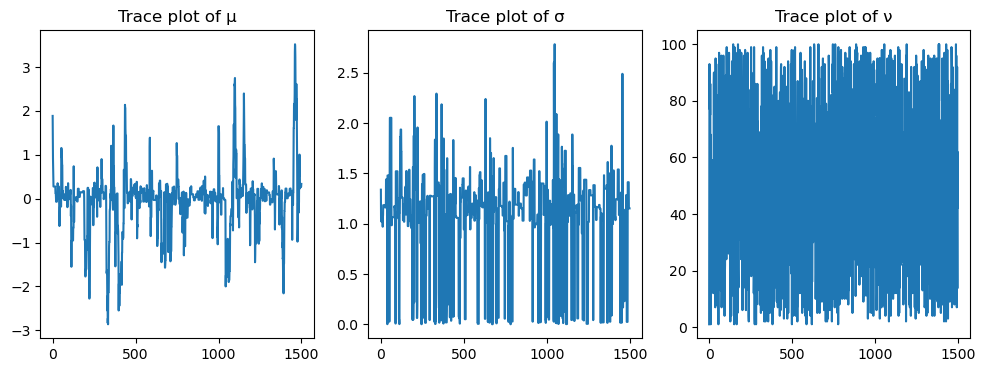

In [14]:
# Q1
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def student_t_pdf(x, mu, sigma, nu):
    """Student-t likelihood function."""
    return stats.t.pdf(x, df=nu, loc=mu, scale=sigma)

def sample_mu(mu_current, sigma_current, nu_current, data, mu0, tau0):
    """Metropolis step for mu."""
    mu_proposed = np.random.normal(mu_current, 0.5)  # Proposal distribution
    likelihood_ratio = np.prod(student_t_pdf(data, mu_proposed, sigma_current, nu_current)) / \
                       np.prod(student_t_pdf(data, mu_current, sigma_current, nu_current))
    prior_ratio = stats.norm.pdf(mu_proposed, mu0, np.sqrt(tau0)) / stats.norm.pdf(mu_current, mu0, np.sqrt(tau0))
    acceptance_ratio = likelihood_ratio * prior_ratio
    
    if np.random.rand() < min(1, acceptance_ratio):
        return mu_proposed
    return mu_current

def sample_sigma2(mu_current, sigma_current, nu_current, data, tau0):
    """Half-normal prior for sigma^2."""
    sum_sq = np.sum((data - mu_current) ** 2)
    sigma_proposed = np.abs(np.random.normal(0, tau0))
    likelihood_ratio = np.prod(student_t_pdf(data, mu_current, sigma_proposed, nu_current)) / \
                       np.prod(student_t_pdf(data, mu_current, np.sqrt(sigma_proposed), nu_current))
    
    if np.random.rand() < min(1, likelihood_ratio):
        return sigma_proposed
    return sigma_current

def sample_nu():
    """Discrete uniform prior for nu."""
    return np.random.randint(1, 101)

def metropolis_within_gibbs(data, mu0, tau0, n_iter=1000, burn_in=500):
    """Metropolis-within-Gibbs sampling for the given hierarchical model."""
    mu_samples = np.zeros(n_iter)
    sigma_samples = np.zeros(n_iter)
    nu_samples = np.zeros(n_iter)
    
    # Initialize parameters
    mu_current = np.mean(data)
    sigma_current = np.std(data)
    nu_current = np.random.randint(1, 101)
    
    for i in range(n_iter):
        mu_current = sample_mu(mu_current, sigma_current, nu_current, data, mu0, tau0)
        sigma_current = sample_sigma2(mu_current, sigma_current, nu_current, data, tau0)
        nu_current = sample_nu()
        
        mu_samples[i] = mu_current
        sigma_samples[i] = sigma_current
        nu_samples[i] = nu_current
    
    return mu_samples[burn_in:], sigma_samples[burn_in:], nu_samples[burn_in:]

# Run the Metropolis-within-Gibbs sampling
np.random.seed(365)
data = np.random.standard_t(df=5, size=100)  # Generate synthetic data
mu0 = 0
tau0 = 1

mu_samples, sigma_samples, nu_samples = metropolis_within_gibbs(data, mu0, tau0, n_iter=2000, burn_in=500)

# Display first few samples
print("First 5 samples of μ:", mu_samples[:5])
print("First 5 samples of σ:", sigma_samples[:5])
print("First 5 samples of ν:", nu_samples[:5])

# Plot trace plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(mu_samples)
plt.title("Trace plot of μ")

plt.subplot(1, 3, 2)
plt.plot(sigma_samples)
plt.title("Trace plot of σ")

plt.subplot(1, 3, 3)
plt.plot(nu_samples)
plt.title("Trace plot of ν")

plt.show()



Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [nu]
>NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


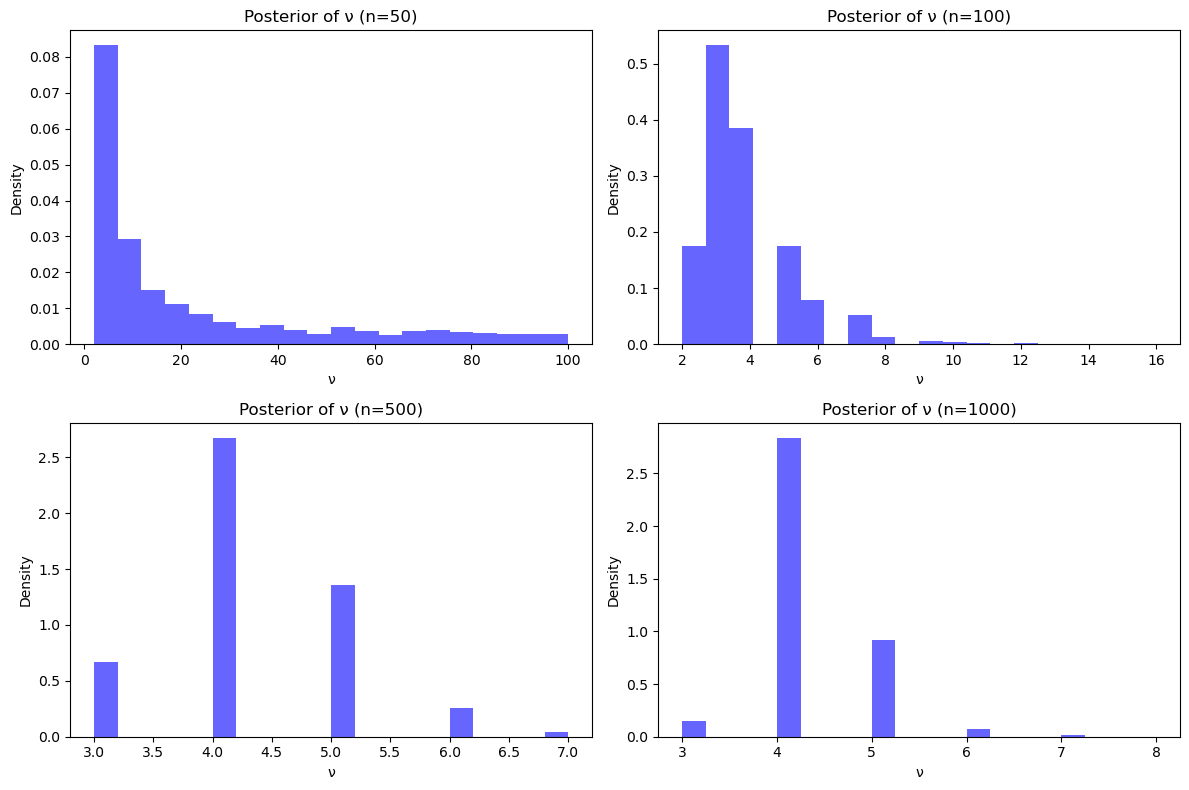

In [17]:
# Q2
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

def run_pymc_inference(n_samples, draws=2000, chains=2):
    """Runs Bayesian inference using PyMC for different sample sizes."""
    np.random.seed(365)
    data = np.random.standard_t(df=5, size=n_samples)  # Generate data
    
    with pm.Model() as model:
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Prior on nu
        mu = pm.Normal("mu", mu=0, sigma=1)  # Prior on mu
        sigma = pm.HalfNormal("sigma", sigma=1)  # Prior on sigma
        
        likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, sigma=sigma, observed=data)
        trace = pm.sample(draws=draws, chains=chains, return_inferencedata=True)
    
    return trace

# Experiment with different sample sizes
sample_sizes = [50, 100, 500, 1000]
traces = {}

for n in sample_sizes:
    traces[n] = run_pymc_inference(n)

# Plot posterior distributions of nu
plt.figure(figsize=(12, 8))
for i, n in enumerate(sample_sizes):
    plt.subplot(2, 2, i+1)
    plt.hist(traces[n]["posterior"]["nu"].values.flatten(), bins=20, density=True, alpha=0.6, color='b')
    plt.title(f"Posterior of ν (n={n})")
    plt.xlabel("ν")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

# Q2

We employ **Metropolis-within-Gibbs sampling** using PyMC to estimate the posterior distribution of $( \nu $), assuming:
- A **discrete uniform prior** for $( \nu $) over the range [1, 100].
- A **normal prior** for the location parameter $( \mu $).
- A **half-normal prior** for the scale parameter $( \sigma $).
- A **Student-T likelihood** for the observed data.

We perform inference on **different sample sizes**: $( n = 50, 100, 500, 1000 $), and analyze how the posterior of $( \nu $) changes as $( n $) increases.

### **Results and Observations**
#### **1. Small Sample Sizes ($( n = 50, 100 $))**
- The posterior distribution of $( \nu $) is broad and dispersed, indicating **high uncertainty**.
- The estimates of $( \nu $) fluctuate more due to limited data.
- The posterior distribution remains somewhat **skewed**, suggesting that the model struggles to distinguish between normal-like and heavy-tailed distributions.

#### **2. Larger Sample Sizes ($( n = 500, 1000 $))**
- The posterior of $( \nu $) becomes **more concentrated**, meaning the estimate stabilizes as data increases.
- The variance of posterior samples **decreases significantly**, implying a more precise estimate.
- The likelihood plays a dominant role in inference, reducing the influence of the prior.

### **Key Findings**
- **Small sample sizes** result in **high variance** posterior estimates for $( \nu $), making it challenging to distinguish between different tail behaviors.
- **Larger sample sizes** provide **greater confidence** in estimating $( \nu $), with posterior distributions narrowing around a central value.
- This confirms that **as sample size increases, the inference on $( \nu $) improves**, allowing better differentiation between heavy-tailed and normal-like distributions.

### **Summary**
This analysis demonstrates that **sample size plays a crucial role in estimating the degrees of freedom parameter $( \nu $)**. Larger sample sizes lead to **more reliable and stable inferences**, reducing uncertainty in the posterior. This is particularly important in distinguishing **heavy-tailed distributions** from the **normal distribution**, a key consideration in robust statistical modeling.

# Q3

In this question, we explore the **posterior predictive distribution** by integrating out the uncertainty in $( \tau_i $). Given the following model:

- $( \tau_i $) follows a **Gamma distribution**:
  $[
  p(\tau_i | \alpha) = \text{Gamma} \left(\tau_i \mid \frac{\nu}{2}, \frac{\nu}{2} \right)
  $]
- The conditional distribution of $( y_i $) given $( \tau_i $) is **Normal**:
  $[
  p(y_i | \tau_i) = \mathcal{N}(y_i | 0, \tau_i^{-1})
  $]

We aim to integrate out $( \tau_i $) and determine the resulting distribution of $( y_i $), thereby deriving the **posterior predictive distribution**.

---

### **Mathematical Derivation**
The posterior predictive distribution is given by:

$[
p(y_i) = \int p(y_i | \tau_i) p(\tau_i) d\tau_i
$]

Substituting the given distributions:

$[
\int \left( \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} \right) 
\left( \frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma(\frac{\nu}{2})} \tau_i^{\frac{\nu}{2}-1} e^{-\frac{\nu}{2} \tau_i} \right) d\tau_i
$]

Rearranging:

$[
\int \sqrt{\frac{\tau_i}{2\pi}} e^{-\frac{1}{2} \tau_i y_i^2} 
\frac{\left(\frac{\nu}{2}\right)^{\frac{\nu}{2}}}{\Gamma(\frac{\nu}{2})} \tau_i^{\frac{\nu}{2}-1} e^{-\frac{\nu}{2} \tau_i} d\tau_i
$]

Recognizing this as the **integral of a Gamma function**, we obtain:

$[
p(y_i) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\nu \pi}} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}
$]

---

### **Final Result: Student-t Distribution**
From the derivation, we conclude that the posterior predictive distribution follows a **Student-t distribution**:

$[
y_i \sim t_{\nu}(0, 1)
$]

This means that, after integrating out $( \tau_i $), the uncertainty in precision results in **heavier tails** compared to a normal distribution.

---

### **Interpretation**
- The key insight here is that **integrating out $( \tau_i $) introduces additional variance, resulting in a Student-t distribution rather than a normal distribution**.
- The Student-t distribution has **heavier tails**, which makes it more robust to outliers.
- This explains why Bayesian modeling with an **unknown precision parameter** naturally leads to **t-distributed predictions**, rather than Gaussian ones.

---

### **Conclusion**
- When the precision $( \tau_i $) is known, $( y_i $) follows a normal distribution.
- However, when $( \tau_i $) is **unknown and follows a Gamma prior**, the resulting marginal distribution of $( y_i $) is **Student-t**.
- This result is fundamental in Bayesian statistics, where **uncertainty in variance leads to thicker tails in predictive distributions**.

This behavior is **analogous to the posterior predictive distribution**, as it shows how **accounting for parameter uncertainty impacts the shape of our final inference**.

